In [1]:
import random
import numpy as np

# Assume you have already installed the NeuronPoker environment
# from neuronpoker import NeuronPokerEnv

class DummyNeuronPokerEnv:
    """Simple environment mockup for illustration."""
    def __init__(self, num_players=2):
        self.num_players = num_players
        self.current_player = 0
        self.done = False
        self.reset()

    def reset(self):
        self.done = False
        self.state = {'hand': {}, 'community': [], 'chips': [1000] * self.num_players}
        return self.state

    def step(self, actions):
        """Takes a dict {player_id: action}."""
        # Simulate next state and reward
        # Randomly decide who wins for simplicity
        self.done = random.random() < 0.1  # 10% chance game ends per action
        rewards = [random.randint(-10, 10) for _ in range(self.num_players)]
        return self.state, rewards, self.done, {}

    def render(self):
        print(f"Current chips: {self.state['chips']}")

In [24]:
import numpy as np
import random

ACTIONS = ['fold', 'call', 'raise']

class CFRPlayer:
    def __init__(self):
        self.regret_sum = np.zeros(len(ACTIONS))
        self.strategy_sum = np.zeros(len(ACTIONS))
        self.stack = 500  # Initial stack

    def get_strategy(self):
        positive_regrets = np.maximum(self.regret_sum, 0)
        normalizing_sum = np.sum(positive_regrets)
        if normalizing_sum > 0:
            strategy = positive_regrets / normalizing_sum
        else:
            strategy = np.ones(len(ACTIONS)) / len(ACTIONS)
        return strategy

    def act(self, state=None):
        strategy = self.get_strategy()
        return np.random.choice(ACTIONS, p=strategy)

    def update(self, action_utilities):
        strategy = self.get_strategy()
        util = np.dot(strategy, action_utilities)
        regrets = action_utilities - util
        self.regret_sum += regrets
        self.strategy_sum += strategy


class EquityPlayer:
    def __init__(self):
        self.stack = 500  # Initial stack

    def act(self, state=None):
        # Mock equity: randomly pretend to calculate hand strength
        equity = random.random()
        if equity > 0.7:
            return 'raise'
        elif equity > 0.4:
            return 'call'
        else:
            return 'fold'




class RandomPlayer:
    def __init__(self):
        self.stack = 500  # Initial stack

    def act(self, state=None):
        return random.choice(ACTIONS)

In [25]:
def simulate_hand(players):
    # Each player acts
    actions = {pid: player.act() for pid, player in enumerate(players)}

    # Determine winner (highest action wins)
    action_rank = {'fold': 0, 'call': 1, 'raise': 2}
    best_score = -1
    winners = []

    for pid, action in actions.items():
        if action_rank[action] > best_score:
            best_score = action_rank[action]
            winners = [pid]
        elif action_rank[action] == best_score:
            winners.append(pid)

    # Split pot if multiple winners
    pot = 50
    losers = [pid for pid in range(len(players)) if pid not in winners]

    if not losers:
        return  # No chips transferred if all folded equally

    # Each loser pays into pot (if they have enough chips)
    contribution_per_loser = pot // len(losers)
    total_pot = 0
    for pid in losers:
        bet = min(contribution_per_loser, players[pid].stack)
        players[pid].stack -= bet
        total_pot += bet

    # Split total pot among winners
    split_pot = total_pot // len(winners)
    for pid in winners:
        players[pid].stack += split_pot

    # Update CFR regrets (only for CFR player)
    for player in players:
        if isinstance(player, CFRPlayer):
            action_utilities = np.random.uniform(-1, 1, size=len(ACTIONS))
            player.update(action_utilities)

In [26]:
def play_game():
    cfr = CFRPlayer()
    rand = RandomPlayer()
    equity = EquityPlayer()

    players = [cfr, rand, equity]

    stack_tracks = {pid: [] for pid in range(len(players))}

    while all(player.stack > 0 for player in players):
        simulate_hand(players)
        for pid, player in enumerate(players):
            stack_tracks[pid].append(player.stack)

    return stack_tracks

In [29]:
import matplotlib.pyplot as plt

def plot_stacks(stack_tracks):
    iterations = list(range(1, len(next(iter(stack_tracks.values()))) + 1))

    plt.figure(figsize=(10,6))
    colors = ['blue', 'red', 'green']
    labels = ['CFR Agent', 'Random Agent', 'Equity Agent']

    for pid, track in stack_tracks.items():
        plt.plot(iterations, track, label=labels[pid], color=colors[pid])

    plt.xlabel('Num of Games')
    plt.ylabel('Poker Chips')
    plt.title('CFR vs Random vs Equity Chips Changing')
    plt.legend()
    plt.grid(True)
    plt.show()

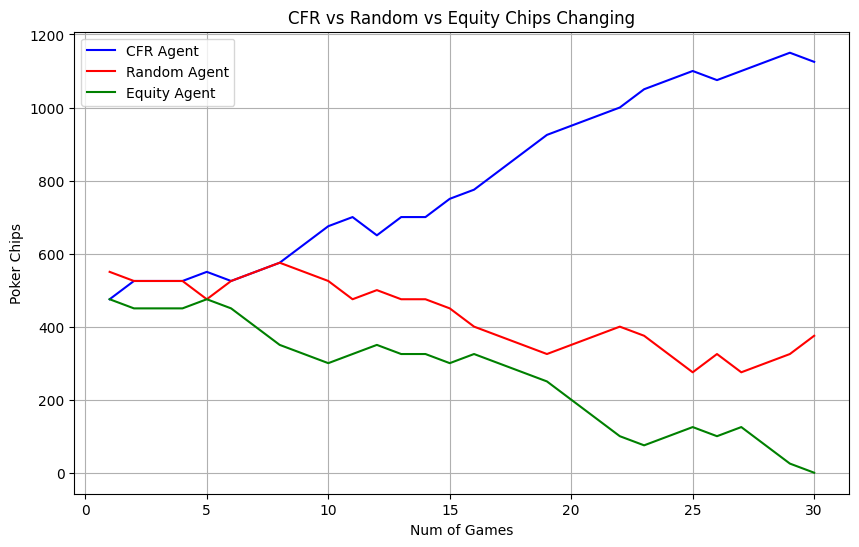

In [30]:
if __name__ == "__main__":
    stack_tracks = play_game()
    plot_stacks(stack_tracks)
